1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN и (RNN -> CNN)
4. сдлать выводы что получилось лучше

In [36]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, Flatten, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping  

import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [3]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [4]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = re.sub("❤", "", txt)
    txt = re.sub("👍", "", txt)
    txt = re.sub("😌", "", txt)
    txt = re.sub("🤗", "", txt)
    txt = re.sub("☝️", "", txt)
    txt = re.sub("😁", "", txt)
    txt = re.sub("👏", "", txt)
    txt = re.sub("👌", "", txt)
    txt = re.sub("😊", "", txt)
    txt = re.sub("😀", "", txt)
    txt = re.sub("😐", "", txt)
    txt = re.sub("😒", "", txt)
    txt = re.sub("😞", "", txt)
    txt = re.sub("😑", "", txt)
    txt = re.sub("😎", "", txt)
    txt = re.sub("😉", "", txt)
    txt = re.sub("😡", "", txt)
    txt = re.sub("👎", "", txt)
    txt = re.sub("😱", "", txt)
    txt = re.sub("😃", "", txt)
    txt = re.sub("😬", " ", txt)
    txt = re.sub("😘", "", txt)
    txt = re.sub("😕", "", txt)
    txt = re.sub("😄", "", txt)
    txt = re.sub("🙌", "", txt)
    txt = re.sub("😇", "", txt)
    txt = re.sub("🙂", "", txt)
    txt = re.sub("☺️", "", txt)
    txt = re.sub("🆗", "", txt)
    txt = re.sub("🙃", "", txt)
    txt = re.sub("😩", "", txt)
    txt = re.sub("😍", "", txt)
    txt = re.sub("😠", "", txt)
    txt = re.sub("🙄", "", txt)
    txt = re.sub("🙁", "", txt)
    txt = re.sub("💪", "", txt)
    txt = re.sub("🤔", "", txt)
    txt = re.sub("🤘", "", txt)
    txt = re.sub("💋", "", txt)
    txt = re.sub("😖", "", txt)
    txt = re.sub("😂", "", txt)
    txt = re.sub("😖", "", txt)
    txt = re.sub("☆", "", txt)
    txt = re.sub("😈", "", txt)
    txt = re.sub("🐺", "", txt)
    txt = re.sub("🐷", "", txt)
    txt = re.sub("🐴", "", txt)
    txt = re.sub("🙋", "", txt)
    txt = re.sub("⭐", "", txt)
    txt = re.sub("😣", "", txt)
    txt = re.sub("😢", "", txt)
    txt = re.sub("😜", "", txt)
    txt = re.sub("😓", "", txt)
    txt = re.sub("✌️", "", txt)
    txt = re.sub("🍓", "", txt)
    txt = re.sub("😤", "", txt)
    txt = re.sub("😯", "", txt)
    txt = re.sub("🔔", "", txt)
    txt = re.sub("📣", "", txt)
    txt = re.sub("❓", "", txt)
    txt = re.sub("❗", "", txt)
    txt = re.sub("😭", "", txt)
    txt = re.sub("😏", "", txt)
    txt = re.sub("😔", "", txt)
    txt = re.sub("🌹", "", txt)
    txt = re.sub("😏", "", txt)
    txt = re.sub("😋", "", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [5]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [6]:
df_train.head()

,id,text,class
0,0,alisachachkaн уезжаааааааать тожена хотеть уез...,0
1,1,rt galyginvadim ребята девчата кино любовь зав...,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0
3,3,rt epupybobv хотеться котлета покиевск запретн...,1
4,4,karinekurganova yessboss босапоп есбосан боять...,1


In [7]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [8]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

In [9]:
X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [10]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [11]:
early_stopping=EarlyStopping(monitor='val_loss')  

### Построим несколько вариантов сетей.

In [61]:
epochs = 10
batch_size = 512
validation_split = 0.1

### CNN

In [64]:
model = Sequential()
model.add(Embedding(input_dim=word_count, input_length=training_length, output_dim=30))
model.add(Conv1D(256, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [65]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=validation_split)

In [66]:
result = []
result.append(history)

In [67]:
score = model.evaluate(X_valid, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 6ms/step - loss: 1.9590 - accuracy: 0.5047


Test score: 1.959035038948059
Test accuracy: 0.5047392249107361


### RNN

### SimpleRNN

In [68]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [69]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=validation_split)

In [70]:
result.append(history)

In [71]:
score = model.evaluate(X_valid, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 19ms/step - loss: 1.9031 - accuracy: 0.7053


Test score: 1.903093934059143
Test accuracy: 0.705329954624176


### LSTM

In [72]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [73]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=validation_split)

In [74]:
result.append(history)

In [75]:
score = model.evaluate(X_valid, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 32ms/step - loss: 1.7903 - accuracy: 0.7134


Test score: 1.7902559041976929
Test accuracy: 0.7133976817131042


### GRU

In [76]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [77]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=validation_split)

In [78]:
result.append(history)

In [79]:
score = model.evaluate(X_valid, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 27ms/step - loss: 1.6630 - accuracy: 0.7062


Test score: 1.6629559993743896
Test accuracy: 0.7061676383018494


### CNN + GRU

In [80]:
model = Sequential()
model.add(Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30))
# model.add(Masking(mask_value=0.0))
model.add(Conv1D(256, 3))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(RepeatVector(1))

model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [81]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=validation_split)

In [82]:
result.append(history)

In [83]:
score = model.evaluate(X_valid, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 9ms/step - loss: 2.1324 - accuracy: 0.7158


Test score: 2.1324386596679688
Test accuracy: 0.7157783508300781


### Результаты

In [84]:
result[0].history

{'loss': [0.544829249382019,
  0.2939998507499695,
  0.10533198714256287,
  0.04598180577158928,
  0.022504640743136406,
  0.011305876076221466,
  0.006092268507927656,
  0.003314983332529664,
  0.001425853930413723,
  0.0009272711467929184],
 'accuracy': [0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893,
  0.5075924396514893],
 'val_loss': [0.48824191093444824,
  0.5440083742141724,
  0.7027420401573181,
  0.8840218186378479,
  1.0600968599319458,
  1.2168993949890137,
  1.3470730781555176,
  1.4974030256271362,
  1.6397292613983154,
  1.7142579555511475],
 'val_accuracy': [0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949,
  0.5049319267272949]}

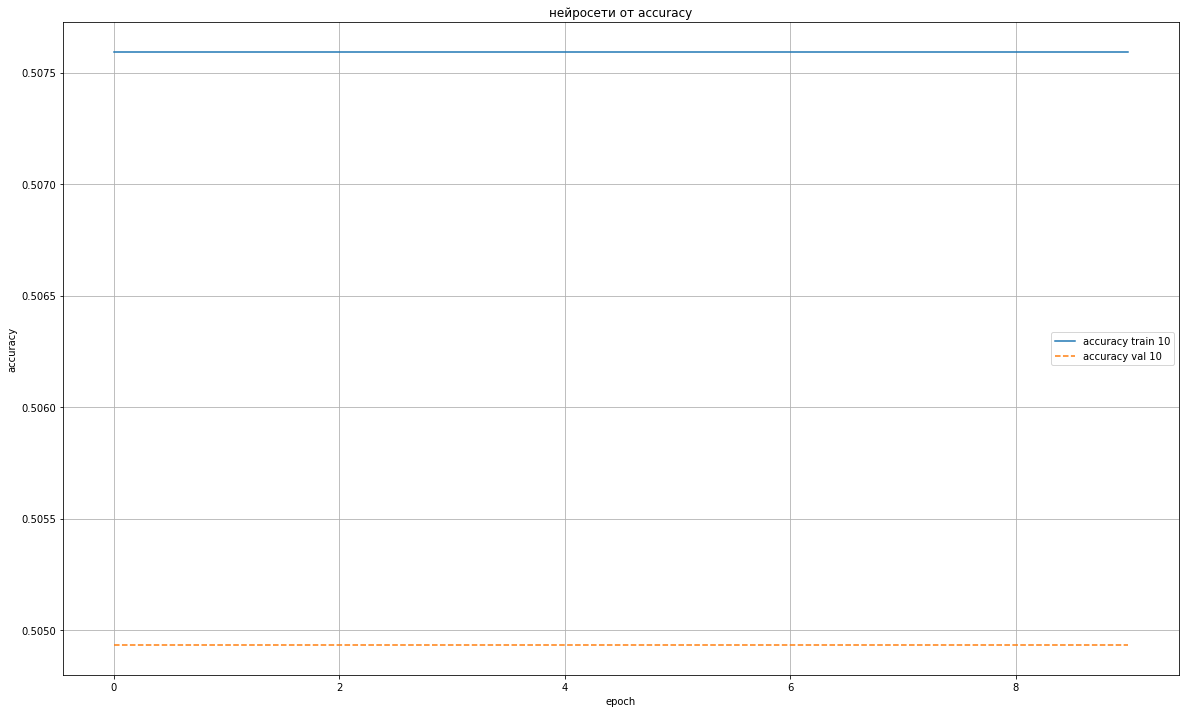

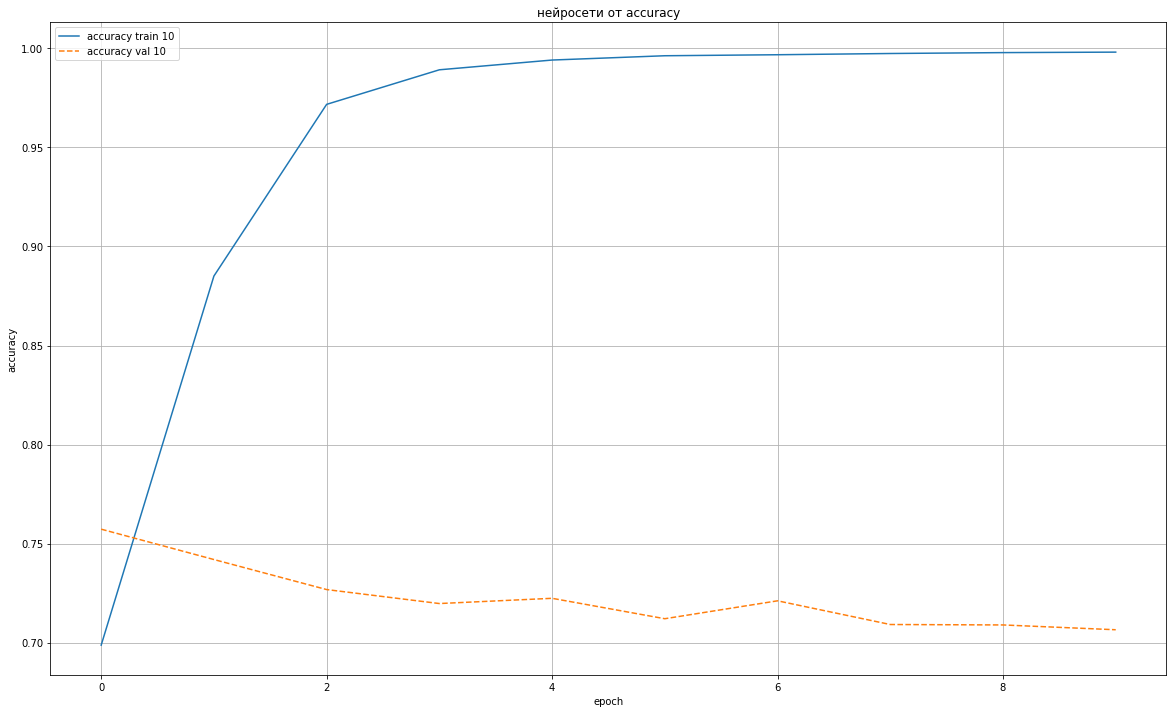

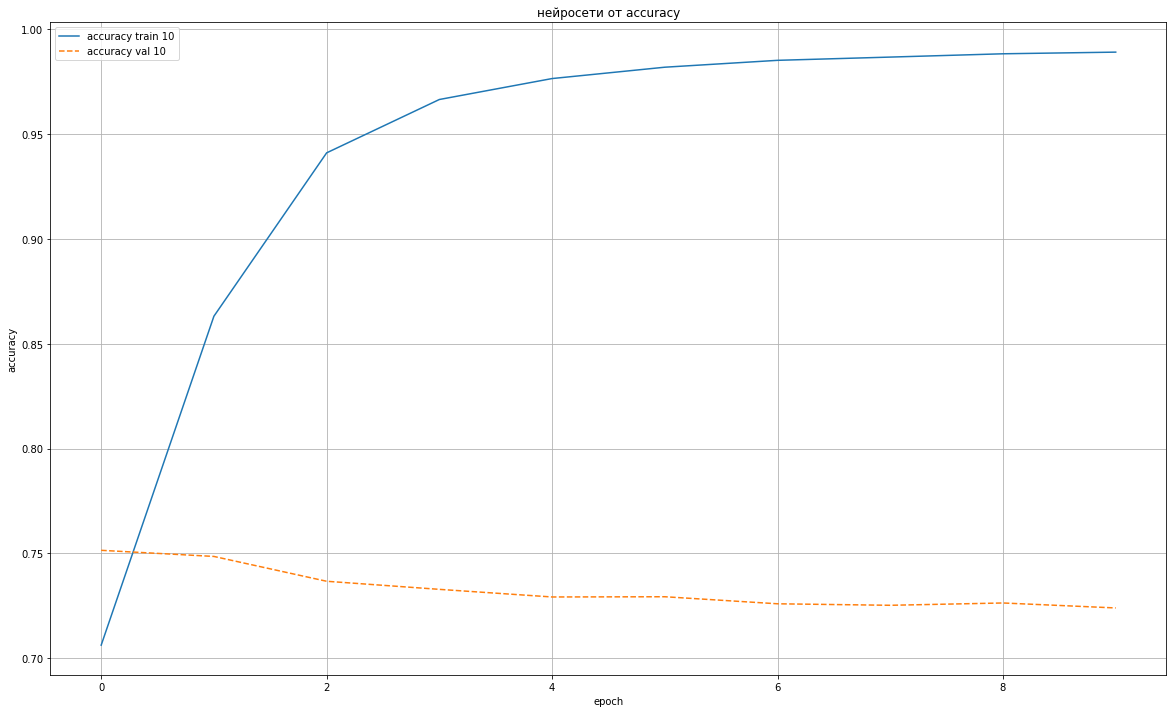

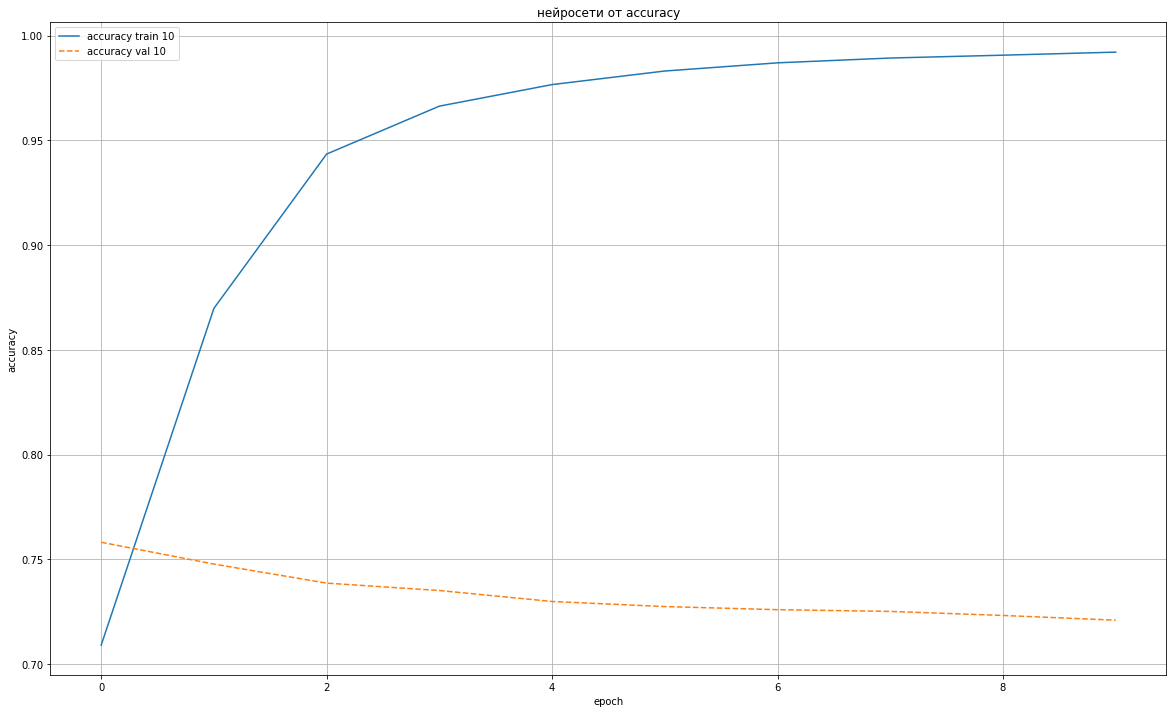

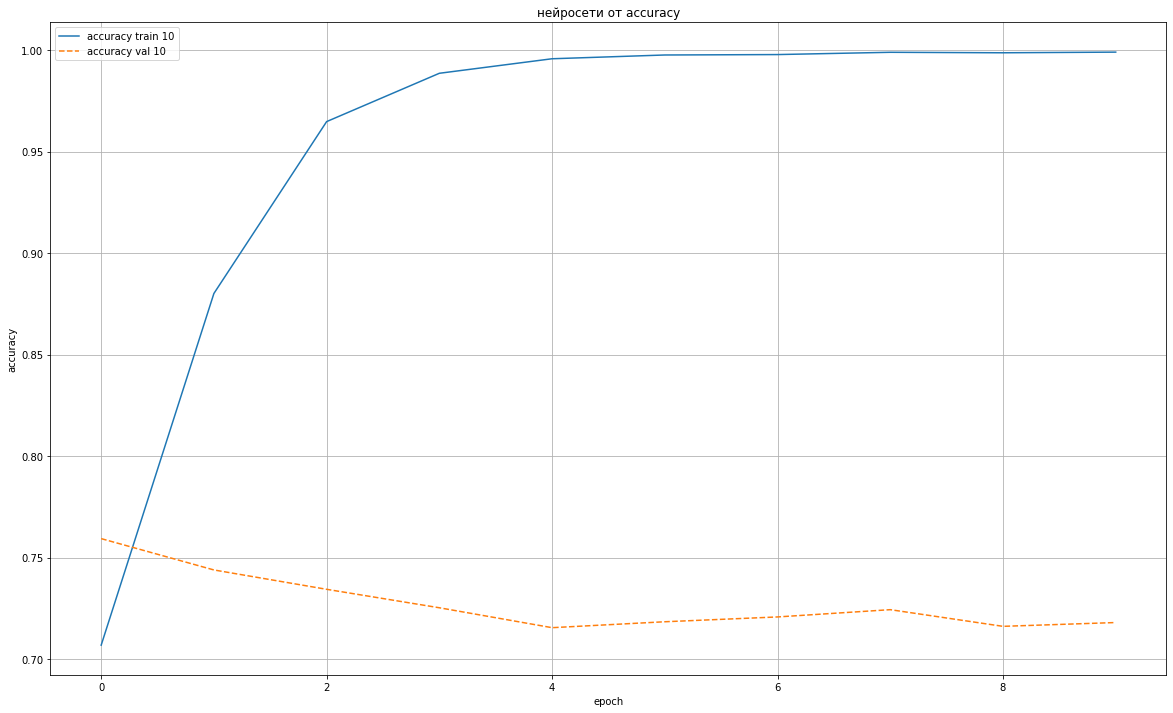

In [85]:
for history in result:
    plt.figure(figsize=(20,12))
    plt.plot(history.history['accuracy'], '-', label = f'accuracy train {epochs}')
    plt.plot(history.history['val_accuracy'], '--', label = f'accuracy val {epochs}')

    plt.legend()
    plt.grid('On')
    plt.title('нейросети от accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
plt.show()

### Чистая RNN имеет точность выше